### 참고
- 넷플릭스
    - 슬로건: 모든 것이 추천
    - https://medium.com/netflixtechblog/55838468f429 : 넷플릭스 추천 알고리즘 구현에 대한 기술 블로그 공개

## 1. 연구 목표
- 사용자 평점 데이터를 기반으로 사용자를 특정, 예측해 추천 시스템 구축
- 회귀 처리, 회귀 평가, 추천시스템에 대한 이해
- FastFM(third party 알고리즘 사용: 인수분해머신 기능 지원)
  - 윈도우에서는 컴파일 후 설치 불가/ 리눅스에서 설치해 진행

## 2. 데이터 수집/확보
- ml-100k.zip 파일
- 영화 정보 데이터(고객 정보/영화 정보/평점 정보)

In [1]:
import pandas as pd

In [2]:
users = pd.read_csv('../table/ml-100k/u.user', sep='|', header=None)

In [3]:
users.columns = ['uid','age','m','job','zip_code']
users.tail(2)

,uid,age,m,job,zip_code
941,942,48,F,librarian,78209
942,943,22,M,student,77841


In [4]:
cols = ['mid','title','release_date','video_release_date','imdb_url']
movies = pd.read_csv('../table/ml-100k/u.item', sep='|', header=None, encoding='latin1', names=cols, usecols=range(5))
movies.tail(3)

,mid,title,release_date,video_release_date,imdb_url
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998)
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...
1681,1682,Scream of Stone (Schrei aus Stein) (1991),08-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Schrei%20aus%...


In [5]:
movies.shape

(1682, 5)

In [6]:
ratings = pd.read_csv('../table/ml-100k/u.data', sep='\t', header=None, names=['uid','mid','rating','unix_timestamp'])
ratings.head(2)

,uid,mid,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742


In [7]:
# unix_timestamp는 1970년 1월 1일 00시 00분 00초부터 현재까지 경과된 시간 +09:00
# 시간 형식 변경
ratings['date'] = pd.to_datetime( ratings.unix_timestamp, unit='s' )
ratings.head(2)

,uid,mid,rating,unix_timestamp,date
0,196,242,3,881250949,1997-12-04 15:55:49
1,186,302,3,891717742,1998-04-04 19:22:22


## 3. 데이터 준비/품질향상/전처리

In [8]:
movies_ratings = pd.merge(movies, ratings, on='mid')
movies_ratings.shape

(100000, 9)

In [9]:
movies_lens = pd.merge(movies_ratings, users)
movies_lens.head(2)

,mid,title,release_date,video_release_date,imdb_url,uid,rating,unix_timestamp,date,age,m,job,zip_code
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532,1998-02-17 17:28:52,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,308,5,887737890,1998-02-17 17:51:30,60,M,retired,95076


- 데이터 병합 완료. 평점이나 회원을 중심으로 중복 데이터 많음
- 데이터가 크면 메모리를 많이 사용할 수도 있음

In [10]:
movies_lens.title.value_counts()[:10]

Star Wars (1977)                 583
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
Name: title, dtype: int64

In [11]:
movies_lens.title.value_counts()[-10:]

Walk in the Sun, A (1945)                       1
Eye of Vichy, The (Oeil de Vichy, L') (1993)    1
Wife, The (1995)                                1
Great Day in Harlem, A (1994)                   1
Sunchaser, The (1996)                           1
Shadow of Angels (Schatten der Engel) (1976)    1
Scream of Stone (Schrei aus Stein) (1991)       1
Touki Bouki (Journey of the Hyena) (1973)       1
Hungarian Fairy Tale, A (1987)                  1
Crude Oasis, The (1995)                         1
Name: title, dtype: int64

## 4. 데이터 분석(통계적,시각적)

- 제목 기준으로 데이터를 분류
- 평가의 개수, 평균 평점이 들어가있는 df
- index: title, column: 개수, 평균평점(컬럼의 레벨이 1이 넘어도 괜찮음)

In [12]:
import numpy as np

In [13]:
# groupby(컬럼): 해당 컬림이 인덱스로 이동
# agg( {컬럼:[값처리함수]} ): 컬럼에 처리함수 개수대로 설정돼 값 자동 처리

In [14]:
movie_state=movies_lens.groupby('title').agg({'rating':[np.size, np.mean]})
movie_state

rating          
                                        size      mean
title                                                 
'Til There Was You (1997)                  9  2.333333
1-900 (1994)                               5  2.600000
101 Dalmatians (1996)                    109  2.908257
12 Angry Men (1957)                      125  4.344000
187 (1997)                                41  3.024390
...                                      ...       ...
Young Guns II (1990)                      44  2.772727
Young Poisoner's Handbook, The (1995)     41  3.341463
Zeus and Roxanne (1997)                    6  2.166667
unknown                                    9  3.444444
Á köldum klaka (Cold Fever) (1994)         1  3.000000

[1664 rows x 2 columns]

- 평점을 받은 개수가 1개인 경우 평균에 잡음의 개입 여지 많음
- 임계값 100개

In [15]:
limit_std_value = 100
condition = movie_state['rating']['size'] >= limit_std_value

In [16]:
movie_state[condition]

rating          
                                               size      mean
title                                                        
101 Dalmatians (1996)                           109  2.908257
12 Angry Men (1957)                             125  4.344000
2001: A Space Odyssey (1968)                    259  3.969112
Absolute Power (1997)                           127  3.370079
Abyss, The (1989)                               151  3.589404
...                                             ...       ...
Willy Wonka and the Chocolate Factory (1971)    326  3.631902
Wizard of Oz, The (1939)                        246  4.077236
Wrong Trousers, The (1993)                      118  4.466102
Young Frankenstein (1974)                       200  3.945000
Young Guns (1988)                               101  3.207921

[338 rows x 2 columns]

In [17]:
# 정렬
tmp = movie_state[condition].sort_values(by=[('rating','mean')], ascending=False)
tmp.head()

rating          
                                   size      mean
title                                            
Close Shave, A (1995)               112  4.491071
Schindler's List (1993)             298  4.466443
Wrong Trousers, The (1993)          118  4.466102
Casablanca (1942)                   243  4.456790
Shawshank Redemption, The (1994)    283  4.445230

In [18]:
# 간단한 시각화
# x축: 평점 개수 / y축: 평가 횟수
from matplotlib import pyplot as plt
%matplotlib inline

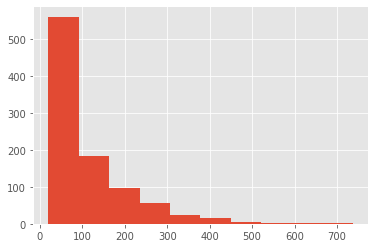

In [19]:
plt.style.use('ggplot')
movies_lens.groupby('uid').size().sort_values(ascending=False).hist()
# 빈도가 점점 낮아짐: 롱테일분포
# '지프의 법칙'을 따른 굴곡 모양

In [20]:
# 사용자별 평가 횟수, 평균
user_state = movies_lens.groupby('uid').agg({'rating':[np.size, np.mean]})
user_state.head()

rating          
      size      mean
uid                 
1      272  3.610294
2       62  3.709677
3       54  2.796296
4       24  4.333333
5      175  2.874286

In [21]:
user_state.shape, user_state.describe()

((943, 2),            rating            
              size        mean
 count  943.000000  943.000000
 mean   106.044539    3.588191
 std    100.931743    0.445233
 min     20.000000    1.491954
 25%     33.000000    3.323054
 50%     65.000000    3.620690
 75%    148.000000    3.869565
 max    737.000000    4.869565)

## 5. 예측모델 구축(머신러닝기반)

- 알고리즘 -> 인수분해 머신 기능을 제공하는 FastFM이라는 모듈 사용
- FastFM
    - c++로 만들어진 libFM이라는 알고리즘
    - libFM을 python으로 구성한 것이 FastFM
    - 기능 :
        - 행렬 인수 분해 일반화: 차원 축소
        - 범주형 변수를 파생변수로 변환하여 범주간의 상호 작용성을 계산
        - 특징간 영향을 주고받는 상호작용 개념을 계산

- FastFM 제공 알고리즘
    - ALS: 교대 최소 제곱법
        - 장점: 예측 시간이 빠름, SGD에 비해 하이퍼파라미터가 적다
        - 단점: 규제 처리(통제) 필요
    - SGD: 확률적 경사 하강법
        - 장점: 예측 시간이 빠름, 빅데이터를 빠르게 처리 학습 가능
        - 단점: 하이퍼파라미터가 많다, 규제 처리(통제) 필요 
    - MCMC: 마르코프 연쇄 몬테카를로
        - 장점: 하이퍼파라미터가 적다
        - 단점: 학습 시간이 느리다

<a href='http://13.125.248.156:8888'>리눅스 주피터 이동</a>

### 가상 데이터를 이용하여 기능 확인

In [26]:
from sklearn.feature_extraction import DictVectorizer
import numpy as np

In [27]:
# DictVectorizer: 문자열만 벡터화 처리
v = DictVectorizer()

In [37]:
# 더미 데이터
# 사용자 ID, 사용자가 평가한 영화 ID, 사용자의 나이
train = [
    {'uid':'1', 'mid':'5', 'age':19},
    {'uid':'2', 'mid':'43', 'age':33},
    {'uid':'3', 'mid':'20', 'age':55},
    {'uid':'4', 'mid':'10', 'age':20},
]

In [38]:
X = v.fit_transform(train)
# 수치는 그대로 배치, 문자열은 벡터화(범주형으로 간주해 케이스별로 0/1로 표시)
X.toarray()

array([[19.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.],
       [33.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
       [55.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.],
       [20.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

In [39]:
# ALS를 이용해 처리
from fastFM import als
from sklearn.model_selection import learning_curve

In [40]:
# user별로 부여한 평점
y = np.array( [5.0, 1.0, 2.0, 4.0] )

In [41]:
# ALS를 이용해 fastFM의 회귀모델을 초기화 후 학습 진행
# 하이퍼파라미터는 임시값 부여
fm = als.FMRegression( n_iter=1000, init_stdev=0.1, rank=2, l2_reg_w=0.1, l2_reg_V=0.5)

In [42]:
fm.fit(X, y)

FMRegression(init_stdev=0.1, l2_reg=0, l2_reg_V=0.5, l2_reg_w=0.1, n_iter=1000,
             random_state=123, rank=2)

In [43]:
# 예측
# ex. 24살인 user가 10번 영화에 대해 부여할 평점 예측하기
# {'uid':'5', 'mid':'10', 'age':24}
fm.predict( v.transform( {'uid':'5', 'mid':'10', 'age':24} ) )

array([3.60775939])

In [50]:
len(test_data), test_y.shape

(9430, (9430,))

In [52]:
# 평가에 참여한 유저들의 ID만 모은 데이터셋, 영화의 ID만 모은 데이터셋
def loadData(fileName, path='../table/ml-100k/'):
    data = list() # 학습용
    y = list() # 평점
    # 중복 데이터를 제거하는 자료구조 생성
    users = set()
    movies = set()
    with open(path + fileName) as f:
        for line in f:
            uid, mid, rating, ts = line.split('\t')
            data.append({'uid':str(uid), 'mid':str(mid)})
            y.append(float(rating))
            users.add(uid)
            movies.add(mid)
    return data, np.array(y), users, movies

In [56]:
dev_data, dev_y, dev_users, dev_movies = loadData('ua.base')
test_data, test_y, test_users, test_movies = loadData('ua.test')

In [57]:
len(dev_users), len(dev_movies), len(test_users), len(test_movies)

(943, 1680, 943, 1129)

In [60]:
len(dev_data), len(dev_y), len(test_data), len(test_y)

(90570, 90570, 9430, 9430)

In [58]:
# 훈련용 데이터의 벡터화
X_dev = v.fit_transform(dev_data)
X_dev.shape

(90570, 2623)

In [59]:
# 테스트용 데이터의 벡터화
X_test = v.fit_transform(test_data)
X_test.shape

(9430, 2072)

In [61]:
# 표준편차 확인: 회귀에서 평가지수 -> 평균 제곱근 오차 계산 시 평가의 잣대
np.std(dev_y), np.std(test_y)

(1.1260664426539722, 1.120180145761465)

In [62]:
from sklearn.model_selection import train_test_split

In [66]:
X_train, X_dev_test, y_train, y_dev_test = train_test_split(X_dev, dev_y, test_size=0.1, random_state=59)

In [67]:
X_train.shape, X_dev_test.shape

((81513, 2623), (9057, 2623))

- 알고리즘 선택
    - mcmc
        - 학습 및 예측 수행
        - 시각화를 통해 수렴해나가는 과정
        - 테스트데이터를 이용한 성능 측정
            - 평균제곱근오차 및 손실함수 이용해 평가
        - 하이퍼파라미터 활용해 평점의 정규화 처리, 성능 평가